In [1]:
import os

import time

import numpy as np

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

2024-11-04 09:54:28.388394: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 09:54:28.415142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 09:54:28.415170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 09:54:28.415182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 09:54:28.420849: I tensorflow/core/platform/cpu_feature_g

In [2]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea


# Covariates simulation

In [3]:
os.chdir("Scripts/")
%run -i covariates.py
os.chdir("../")

In [4]:
seed_to_use = 42

tf.random.set_seed((seed_to_use))
np.random.seed((seed_to_use))

seed_individuals = tfp.random.split_seed( seed_to_use, n=5, salt='seed_synthetic_pop')
seed_carry       = seed_individuals[4]

n_cities = 10

cities_std = tfp.distributions.Gamma(concentration = 10, rate = 12).sample((n_cities, 2), seed = seed_individuals[0])

centroids = tfp.distributions.Uniform(low = [0.0, 0.0], high = [10.0, 10.0]).sample(n_cities, seed = seed_individuals[1])

nr_individuals_per_city = 5000

covariates_rv_list = [tfp.distributions.Normal(loc = 0.0, scale = 1.0)]

covariates_df = make_covariates(n_cities, nr_individuals_per_city, cities_std, centroids, covariates_rv_list, seed_individuals[2])

2024-10-31 10:27:59.250728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:27:59.360458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:27:59.360500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:27:59.363764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-31 10:27:59.363824: I tensorflow/compile

In [5]:
N = 50000

seed_to_use = 42
tf.random.set_seed((seed_to_use))
np.random.seed((seed_to_use))

seed_individuals = tfp.random.split_seed( seed_to_use, n=5, salt='seed_synthetic_pop')

categorical_prob = tfp.distributions.Dirichlet(concentration=tf.ones(3)).sample(seed = seed_individuals[4])
covariates_df = pd.DataFrame({"x":tfp.distributions.Uniform(low = 0.0, high = 10.0).sample(N, seed = seed_individuals[0]), 
			   "y":tfp.distributions.Uniform(low = 0.0, high = 10.0).sample(N, seed = seed_individuals[1]),
			   "covariate0":tfp.distributions.Normal(loc = 2.0, scale = 5.0).sample(N, seed = seed_individuals[2]), 
			   "covariate1":tfp.distributions.Categorical(probs = categorical_prob).sample(N, seed = seed_individuals[3]),})

(array([8.49828115e-05, 1.39749544e-03, 1.05567537e-02, 3.98569431e-02,
        7.34912552e-02, 6.86519556e-02, 3.27419925e-02, 8.16307117e-03,
        1.03867904e-03, 8.02615442e-05]),
 array([-18.7840271 , -14.54787636, -10.31172657,  -6.07557583,
         -1.83942568,   2.3967247 ,   6.63287497,  10.86902523,
         15.10517597,  19.34132576,  23.5774765 ]),
 <BarContainer object of 10 artists>)

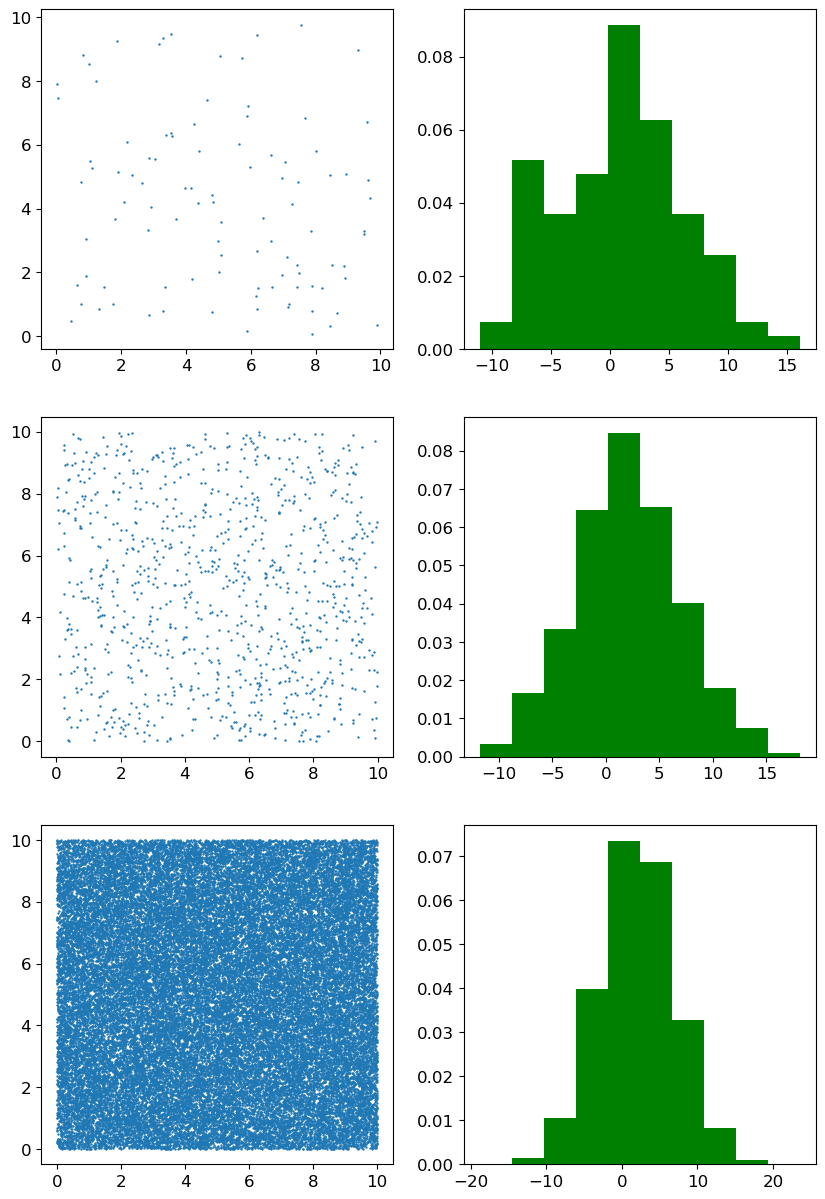

In [6]:
fig, ax = plt.subplots(3, 2, figsize = (10, 15))

pop = 100
ax[0,0].scatter(covariates_df[["x"]][:pop], covariates_df[["y"]][:pop], s = 0.5)
ax[0,1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")

pop = 1000
ax[1,0].scatter(covariates_df[["x"]][:pop], covariates_df[["y"]][:pop], s = 0.5)
ax[1,1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")

ax[2,0].scatter(covariates_df[["x"]][:], covariates_df[["y"]][:], s = 0.5)
ax[2,1].hist(covariates_df[["covariate0"]], density = True, color = "green")

We can normalize the covariates

In [7]:
covariates_df["covariate1"] = (covariates_df["covariate0"]-covariates_df["covariate0"].mean())/covariates_df["covariate0"].std()
covariates_df["covariate0"] = covariates_df["covariate0"]/covariates_df["covariate0"]


(array([0.00042434, 0.00697797, 0.05271199, 0.19901368, 0.36695651,
        0.34279293, 0.16348731, 0.04075985, 0.00518633, 0.00040076]),
 array([-4.16778564, -3.31940174, -2.47101784, -1.62263393, -0.77425003,
         0.07413387,  0.92251778,  1.77090168,  2.61928558,  3.46766949,
         4.31605339]),
 <BarContainer object of 10 artists>)

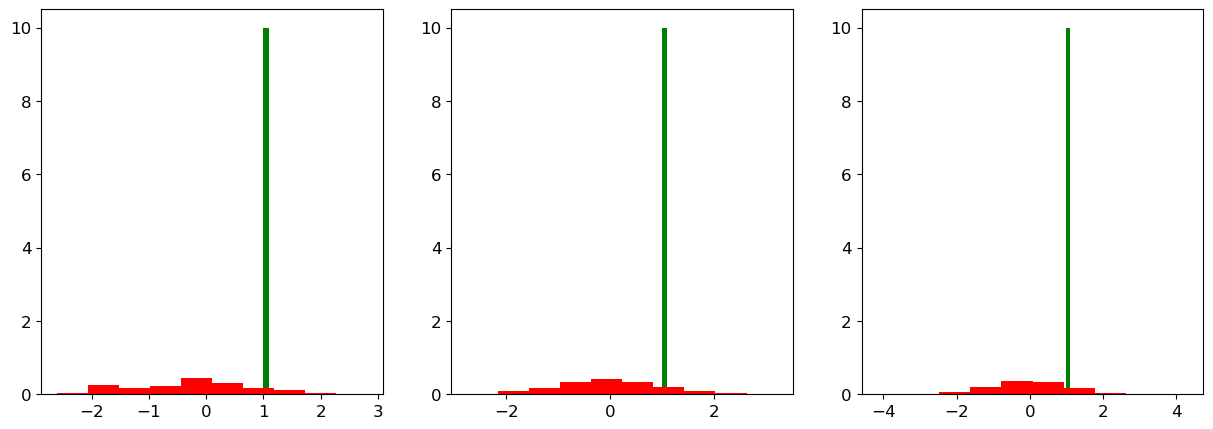

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

pop = 100
ax[0].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")
ax[0].hist(covariates_df[["covariate1"]][:pop], density = True, color = "red")

pop = 1000
ax[1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")
ax[1].hist(covariates_df[["covariate1"]][:pop], density = True, color = "red")

ax[2].hist(covariates_df[["covariate0"]], density = True, color = "green")
ax[2].hist(covariates_df[["covariate1"]], density = True, color = "red")

In [9]:
locations  = tf.stack((covariates_df["x"], covariates_df["y"]), axis =1)
covariates = tf.stack((covariates_df["covariate0"], 
                       covariates_df["covariate1"]), axis =1)

# np.save("Data/SpatialInference/Input/locations.npy", locations)
# np.save("Data/SpatialInference/Input/covariates.npy", covariates)

# Simple SIS

In [10]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [11]:
N_pop = 1000
covariates = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)[:N_pop,:]

N = tf.shape(covariates)[0]

parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.5], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.5], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2], dtype = tf.float32)),}

SIS = basic_SIS(covariates)

In [15]:
np.std(covariates[:,1])

0.99968255

2.468843936920166


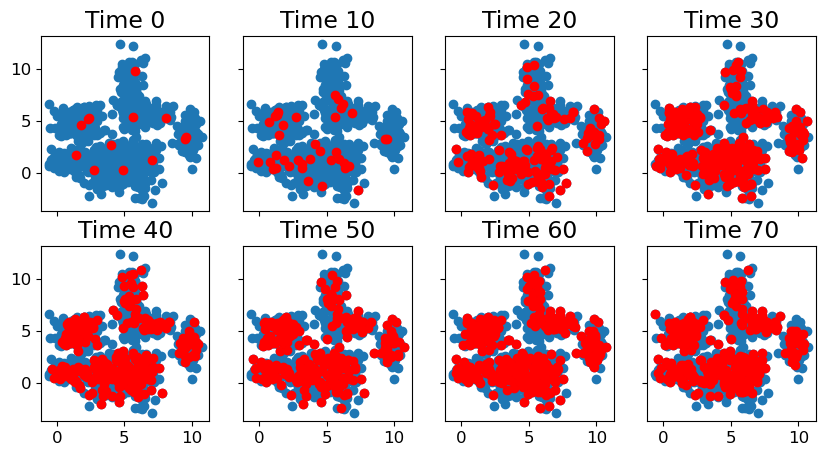

In [12]:
T    = 200
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 10*(i*4+j)

        infected = tf.where(X[t,0,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

In [65]:
os.chdir("Scripts/")
%run -i CAL.py
%run -i CAL_without_correction.py
os.chdir("../")

In [66]:
T = 200
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

2.2757413387298584


The time lap is  0.7892322540283203
The log-likelihood is  -94173.58


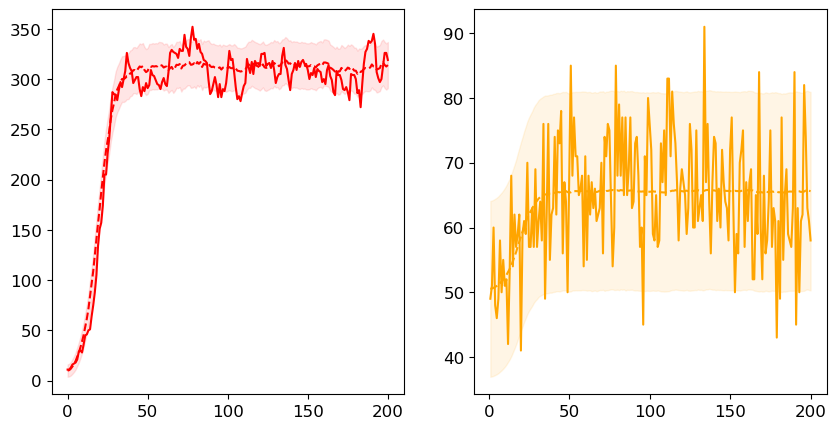

In [67]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

The time lap is  0.7794570922851562
The log-likelihood is  -94173.58


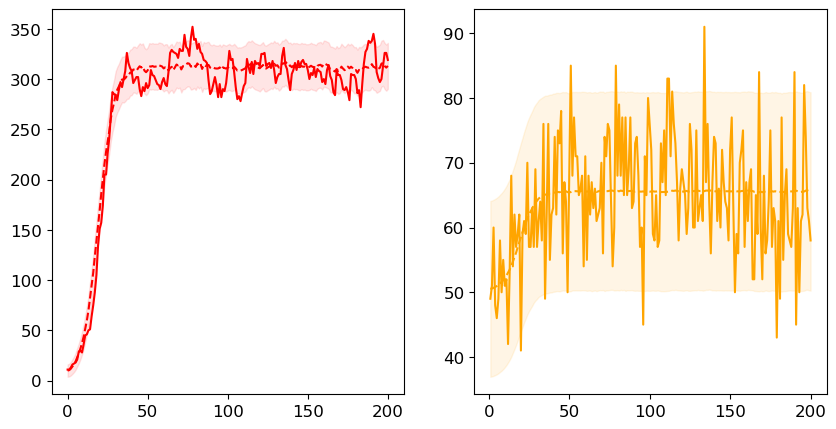

In [68]:
start = time.time()
Pi, Nu, Mu, log_likelihood = CAL_without_correction(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [69]:
n_gradient_steps = 1000

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_sensitivity":1, "logit_specificity":1 }
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

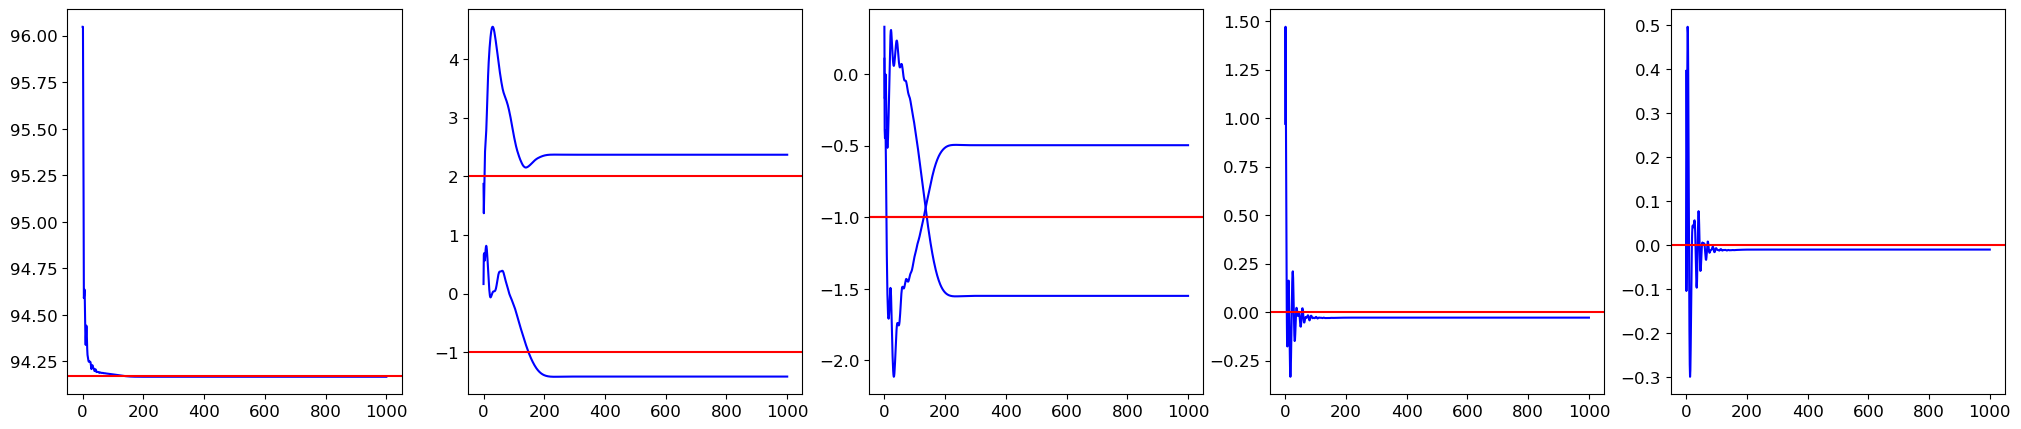

In [70]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
    # print(key)
    for i in range(learning_parameters[key]):
        # print(i)
        ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
        ax[counter+1].axhline(parameters[key][i], color = "red")
    
    counter = counter +1

In [71]:
n_gradient_steps = 1000

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_sensitivity":1, "logit_specificity":1 }
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_without_correction_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

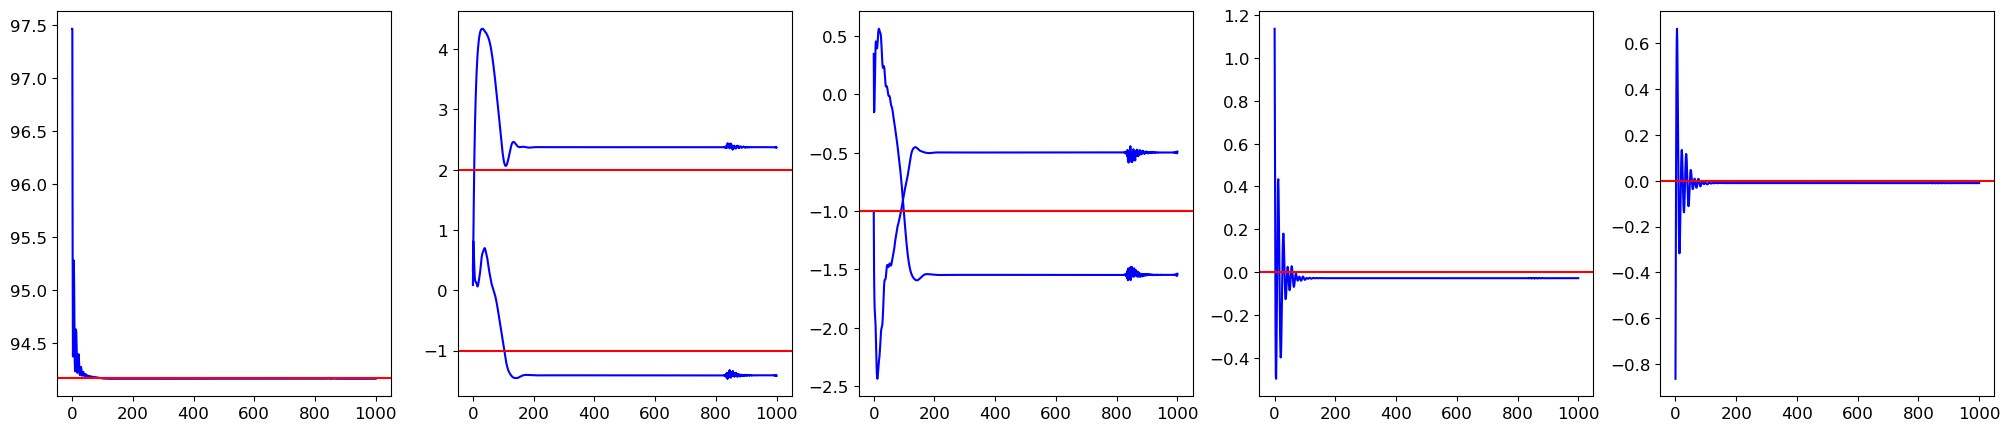

In [72]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
    # print(key)
    for i in range(learning_parameters[key]):
        # print(i)
        ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
        ax[counter+1].axhline(parameters[key][i], color = "red")
    
    counter = counter +1

# Spatial SIS

In [49]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [55]:
N_pop = 1000
covariates = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)[:N_pop,:]
# locations  = (locations - tf.reduce_mean(locations, axis = 0, keepdims=True))/tf.math.reduce_std(locations, axis = 0, keepdims=True)

N = tf.shape(locations)[0]
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-2.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "log_phi":tf.math.log(
                tf.convert_to_tensor([2.0], dtype = tf.float32)),
              "log_chi":tf.math.log(
                tf.convert_to_tensor([50.0], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
		"log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}

SIS = spatial_SIS(locations, covariates)


1.5525846481323242


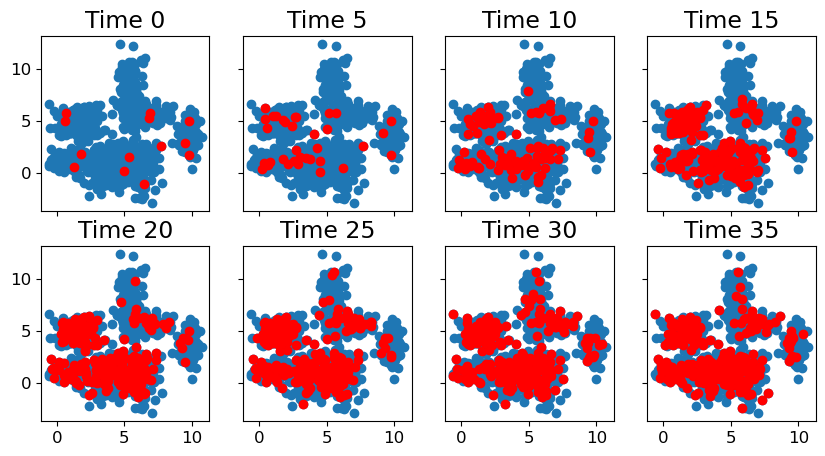

In [56]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 5*(i*4+j)

        infected = tf.where(X[t,0,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

The time lap is  0.7989935874938965
The log-likelihood is  -70049.4


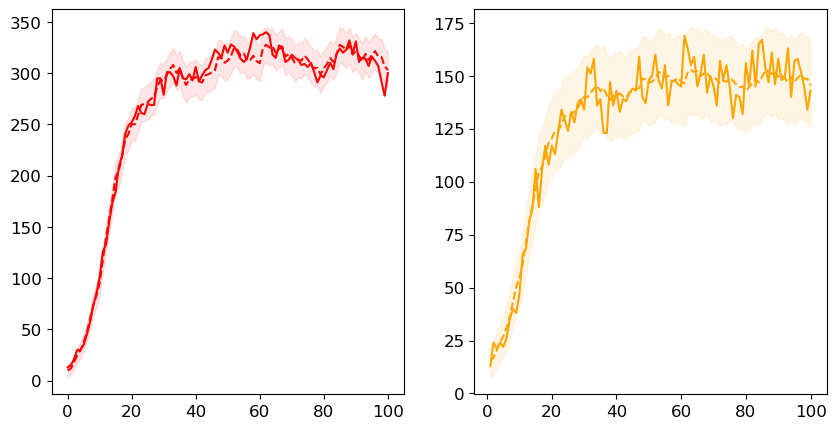

In [57]:
# T = 200
# start = time.time()
# X, Y = simulator(SIS, parameters, T)
# print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

start = time.time()
Pi, Mu, log_likelihood_wrong = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood_wrong.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [58]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
		"log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "log_phi":1, "log_chi":1}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2024-09-16 10:45:54.053006: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_58', 128 bytes spill stores, 128 bytes spill loads



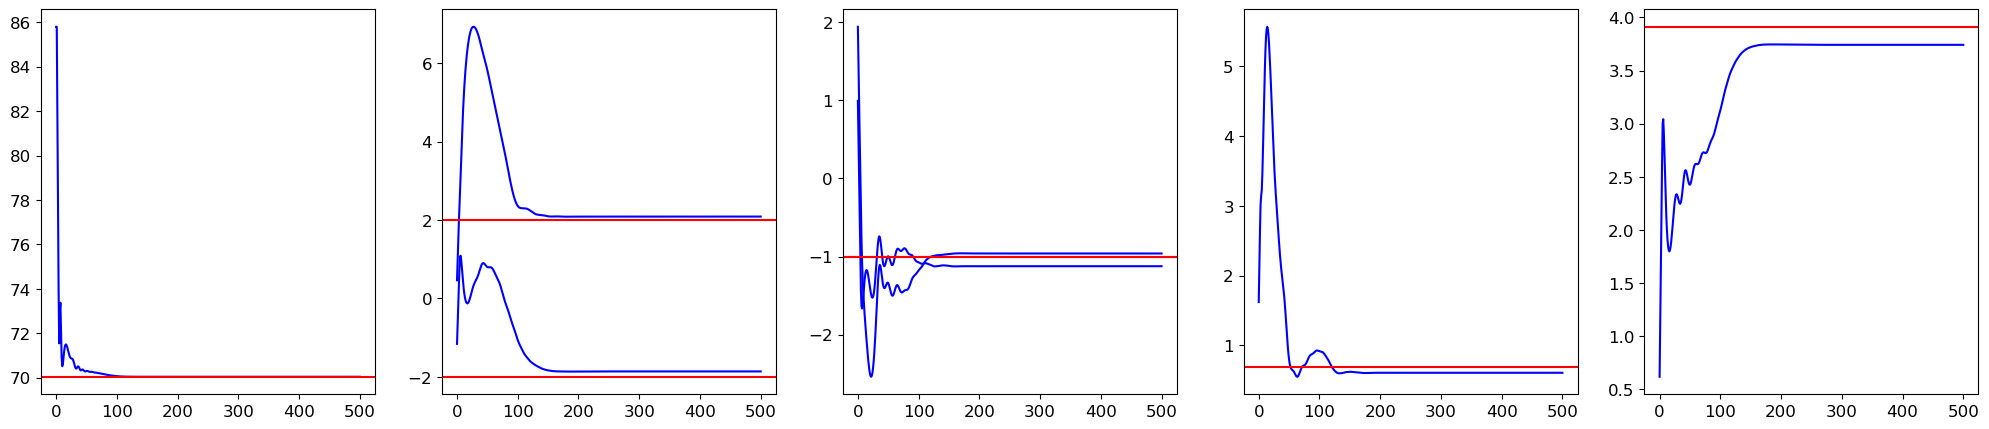

In [59]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

In [24]:
n_gradient_steps = 200

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.001, 0.001], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32))}

learning_parameters = {"beta_l":2, "beta_g":2, "log_phi":1, "logit_prob_testing":2}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2024-09-05 11:25:56.239164: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_63', 224 bytes spill stores, 224 bytes spill loads



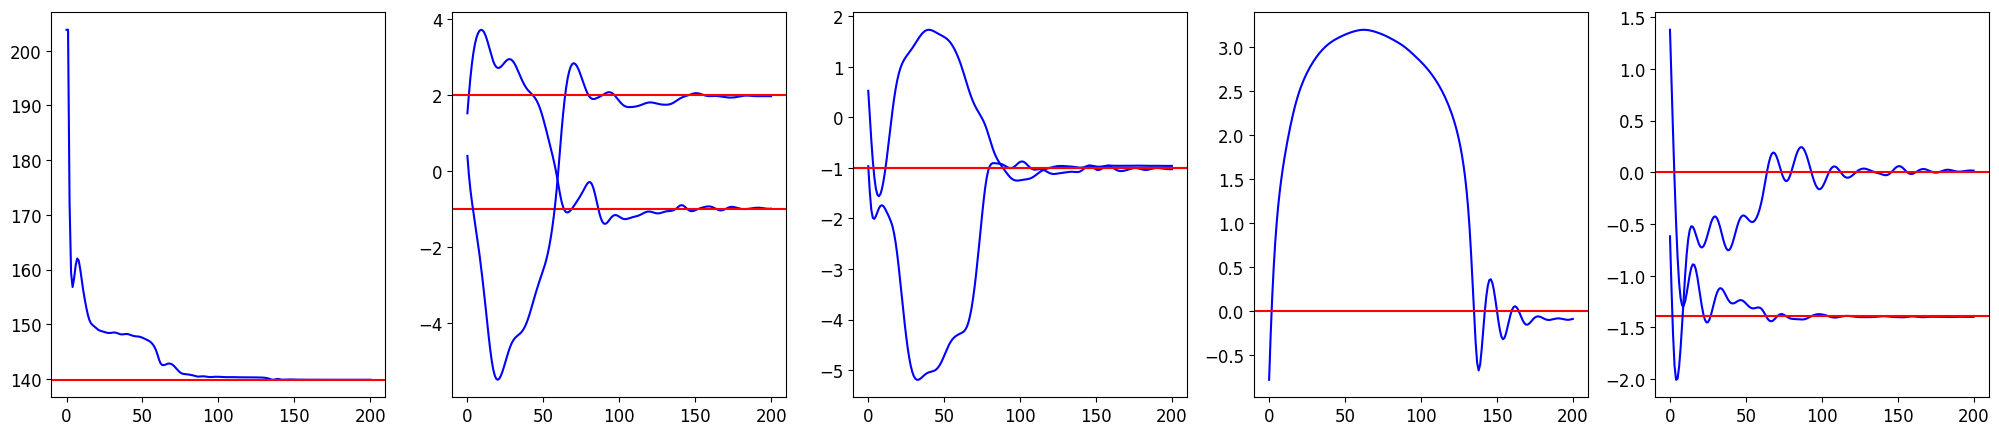

In [52]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

# An asymptotic result for the Stochastic block model SIS

In [5]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [6]:
Ncommunities = 3

B = tf.convert_to_tensor([[0.80, 0.50, 0.00],
			  [0.50, 0.60, 0.05],
			  [0.00, 0.05, 0.10]], dtype = tf.float32)

N = 1000000

initial_distribution = tf.convert_to_tensor([0.4, 0.3, 0.3], dtype = tf.float32)

communities = tfp.distributions.Categorical(probs = initial_distribution).sample(N)
communities = tf.one_hot(communities, Ncommunities)

prior_covariates = tf.convert_to_tensor([1.0, 0.0, -1.0], dtype = tf.float32)

covariates = tf.einsum("nc,c->n", communities, prior_covariates)


In [7]:
N = 1000
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "B_matrix":B,
              "beta_l":tf.convert_to_tensor([-1.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([1.0], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([1.0], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
                tf.convert_to_tensor([0.001], dtype = tf.float32)),}

SIS = sbm_SIS_finite(communities[:N,...], covariates[:N])

In [8]:
n_sim = 10
T    = 150
X, Y = simulator(SIS, parameters, T, sample_size = n_sim)

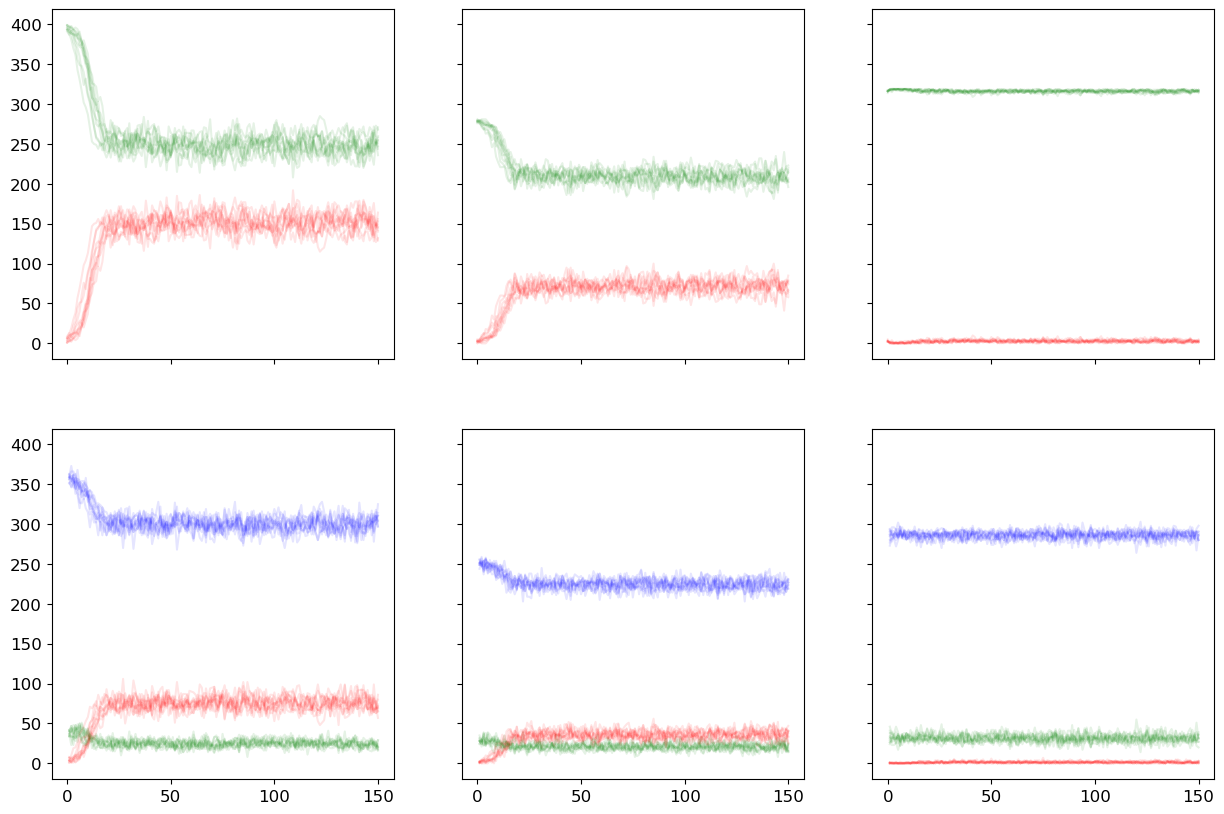

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10), sharex=True, sharey=True)

X_communities = tf.einsum("...nm,nc->...cm", X, communities[:N,...])
Y_communities = tf.einsum("...nm,nc->...cm", Y, communities[:N,...])

time = np.linspace(0, T, T+1)

for sim in range(n_sim):

	for c in range(3):

		ax[0,c].plot(time, X_communities[:,sim, c, 0], color = "green", alpha = 0.1)
		ax[0,c].plot(time, X_communities[:,sim, c, 1], color = "red", alpha = 0.1)

		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 0], color = "blue", alpha = 0.1)
		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 1], color = "green", alpha = 0.1)
		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 2], color = "red", alpha = 0.1)

In [2]:
SIS_limit = sbm_SIS_finite(tf.eye(3), prior_covariates)

pi_0_inf = SIS_limit.pi_0(parameters)

def body(input, t):

	pi_tm1_inf = input

	return tf.einsum("ci,cij->cj", pi_tm1_inf, SIS_limit.K_x(parameters, pi_tm1_inf))

Pi_inf = tf.scan(body, tf.range(0, T), initializer = pi_0_inf)
Pi_inf = tf.concat((tf.expand_dims(pi_0_inf, axis =0), Pi_inf), axis = 0)

NameError: name 'sbm_SIS_finite' is not defined

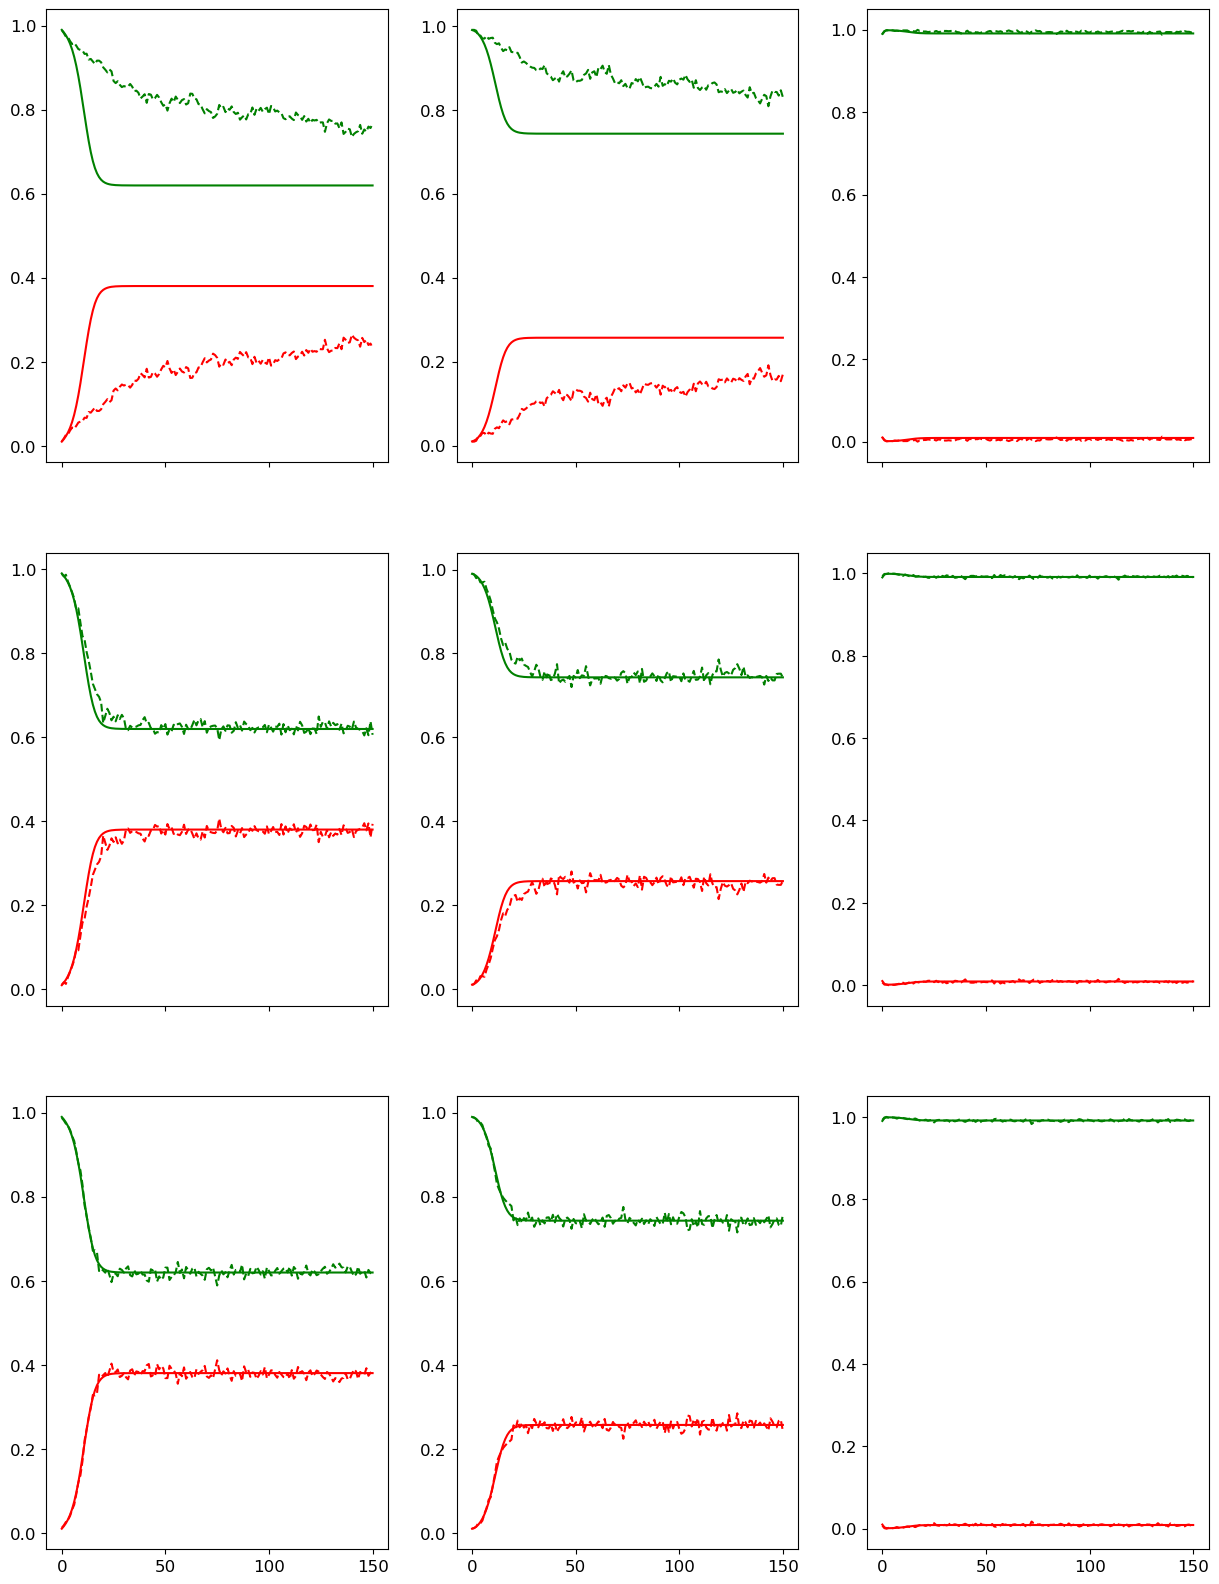

In [19]:
fig, ax = plt.subplots(3, 3, figsize = (15, 20), sharex=True)

N_label = [50, 500, 5000]
labels = [1, 3, 2]

time = np.linspace(0, T, T+1)

n_sim = 100
T    = 150

for n in range(3):
	SIS = sbm_SIS_finite(communities[:N_label[n],...], covariates[:N_label[n]])

	X, Y = simulator(SIS, parameters, T, sample_size = n_sim)
	for c in range(3):

		X_reweighted = tf.einsum("...nm,nc->...cm", X[...,:N_label[0],:], communities[:N_label[0],...]/tf.reduce_sum(communities[:N_label[0],...], axis = 0, keepdims=True))

		X_empirical = tf.reduce_mean(X_reweighted[...,c,:], axis = 1)

		ax[n,c].plot(time, X_empirical[:, 0], color = "green", linestyle='dashed')
		ax[n,c].plot(time, X_empirical[:, 1], color = "red", linestyle='dashed')

		ax[n,c].plot(time, Lambda_inf[:,c, 0], color = "green", )
		ax[n,c].plot(time, Lambda_inf[:,c, 1], color = "red", )

		# ax[1,c].plot(time[1:], Y_communities[:,sim, c, 0], color = "blue", alpha = 0.1)
		# ax[1,c].plot(time[1:], Y_communities[:,sim, c, 1], color = "green", alpha = 0.1)
		# ax[1,c].plot(time[1:], Y_communities[:,sim, c, 2], color = "red", alpha = 0.1)

# Stochastic block model SIS

In [92]:
import networkx as nx

In [93]:
# Ncommunities = 5

# B = 0.95*tf.eye(Ncommunities)
# sovra_diag       = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), tf.eye(Ncommunities-1)), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
# sovra_sovra_diag = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), sovra_diag[:-1,:-1]), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
# sovra_sovra_sovra_diag = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), sovra_sovra_diag[:-1,:-1]), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
# B = tf.experimental.numpy.triu(B + 0.25*sovra_diag + 0.125*sovra_sovra_diag + 0.05*sovra_sovra_sovra_diag)
# B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))

# N = 50000
# initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(10, 5, Ncommunities))).sample()

# communities = tfp.distributions.Categorical(probs = initial_distribution).sample(N)
# communities = tf.one_hot(communities, Ncommunities)

# np.save("data/communities.npy", communities.numpy())
# np.save("data/B.npy", B.numpy())

In [94]:
N_pop = 1000
covariates  = tf.convert_to_tensor(np.load("Data/GraphInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]
communities = tf.convert_to_tensor(np.load("Data/GraphInference/Input/communities.npy"), dtype = tf.float32)[:N_pop,:]

In [96]:
os.chdir("Scripts/")
%run -i model.py
# %run -i CAL_without_correction.py
%run -i CAL.py
os.chdir("../")

In [98]:
N = tf.shape(covariates)[0]
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
        #       "logit_B":logit(B),
	      "log_graph":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
                tf.convert_to_tensor([0.001], dtype = tf.float32)),}

SIS = sbm_SIS(communities, covariates)

B = SIS.B_matrix(parameters)
nodes = range(B.shape[0])
G = nx.Graph()
for i in nodes:
    for j in nodes:
        if i > j and B.numpy()[i, j]!=0:
            G.add_edge(i, j, weight=10*B.numpy()[i, j])

1.7799272537231445


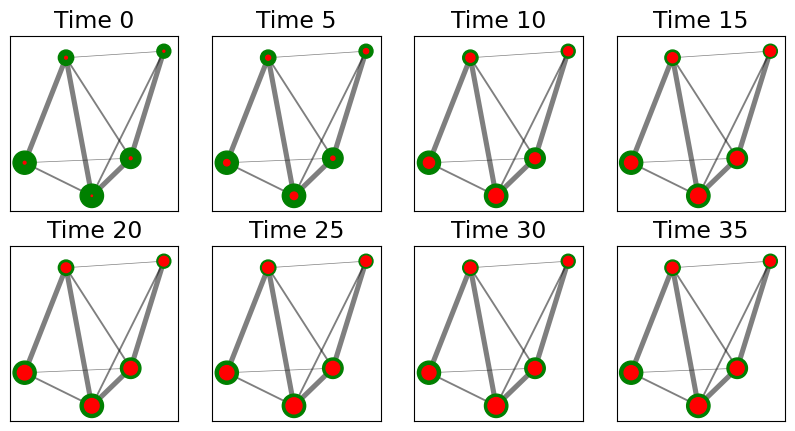

In [99]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

population = tf.reduce_sum(X, axis = 1)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
	for j in range(4):

		t = 5*(i*4+j)

		ax[i, j].set_title("Time "+str(t))
		
		current_state = tf.einsum("tns,nc->tcs", X, SIS.communities)[t,...]
		percentage    = current_state/tf.reduce_sum(current_state, axis = 1, keepdims=True)

		pos = nx.spring_layout(G, seed = 10)  # Positions for all nodes
		weight_labels = nx.get_edge_attributes(G, 'weight')

		color_map = ["green" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
					node_color = color_map, node_shape='o', node_size = tf.reduce_sum(SIS.communities, axis = 0),
					ax = ax[i,j])

		color_map = ["red" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
			 		node_color=color_map, node_shape='o', node_size = tf.reduce_sum(SIS.communities, axis = 0)*percentage[:,1],
					ax = ax[i,j])
		
		nx.draw_networkx_edges( G, pos, 
			 		edgelist = weight_labels.keys(), width=list(weight_labels.values()), edge_color='black', alpha=0.5,
					ax = ax[i,j])

In [81]:
# log_likelihood_CAL_list = []
# log_likelihood_BCAL_list = []

# for i in range(20):

# 	T = 100
# 	X, Y = simulator(SIS, parameters, T)

# 	X, Y = X[:,0,...], Y[:,0,...]

# 	_, _, log_likelihood_CAL = CAL(SIS, parameters, Y)

# 	_, _, log_likelihood_BCAL = CAL_without_correction(SIS, parameters, Y)

# 	log_likelihood_CAL_list.append(log_likelihood_CAL)
# 	log_likelihood_BCAL_list.append(log_likelihood_BCAL)

1.7754936218261719
The time lap is  1.0242013931274414
The log-likelihood is  -76148.78


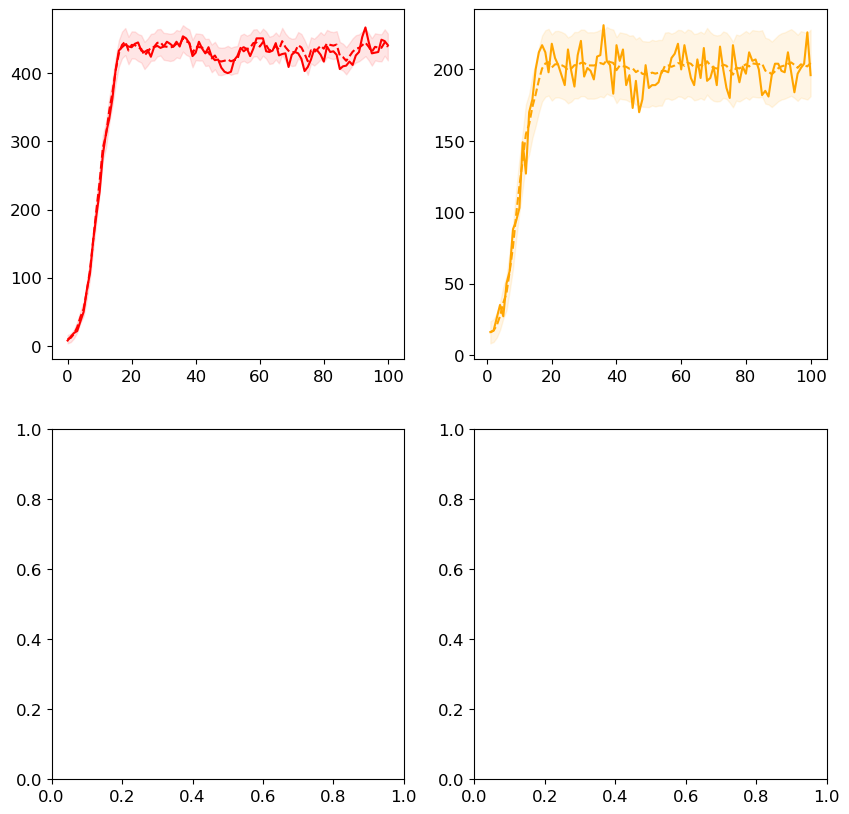

In [101]:
T = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(2, 2, figsize = (10, 10))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0,0].plot(time_steps, population[...,1], color = "red")
ax[0,0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0,0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[0,1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[0,1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[0,1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

# start = time.time()
# Pi, Mu, log_likelihood_wrong = CAL_without_correction(SIS, parameters, Y)
# print("The time lap is ", time.time()-start)
# print("The log-likelihood is ", log_likelihood_wrong.numpy())

# population = tf.reduce_sum(X, axis = 1)
# mean_Pi = tf.reduce_sum(Pi, axis = 1)
# var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

# obs_population = tf.reduce_sum(Y, axis = 1)
# mean_Mu = tf.reduce_sum(Mu, axis = 1)
# var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

# time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

# ax[1,0].plot(time_steps, population[...,1], color = "red")
# ax[1,0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
# ax[1,0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

# ax[1,1].plot(time_steps[1:], obs_population[...,2], color = "orange")
# ax[1,1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
# ax[1,1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [47]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.003, 0.003], dtype = tf.float32),
              "log_graph":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":2}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_without_correction_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

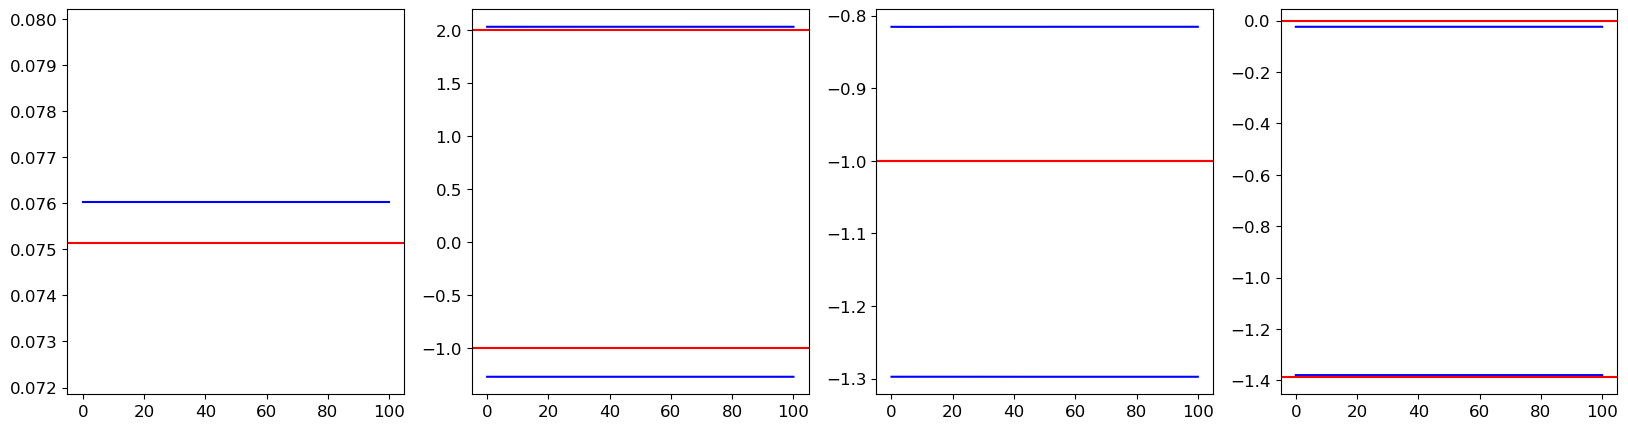

In [51]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor[400:], color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i][400:], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

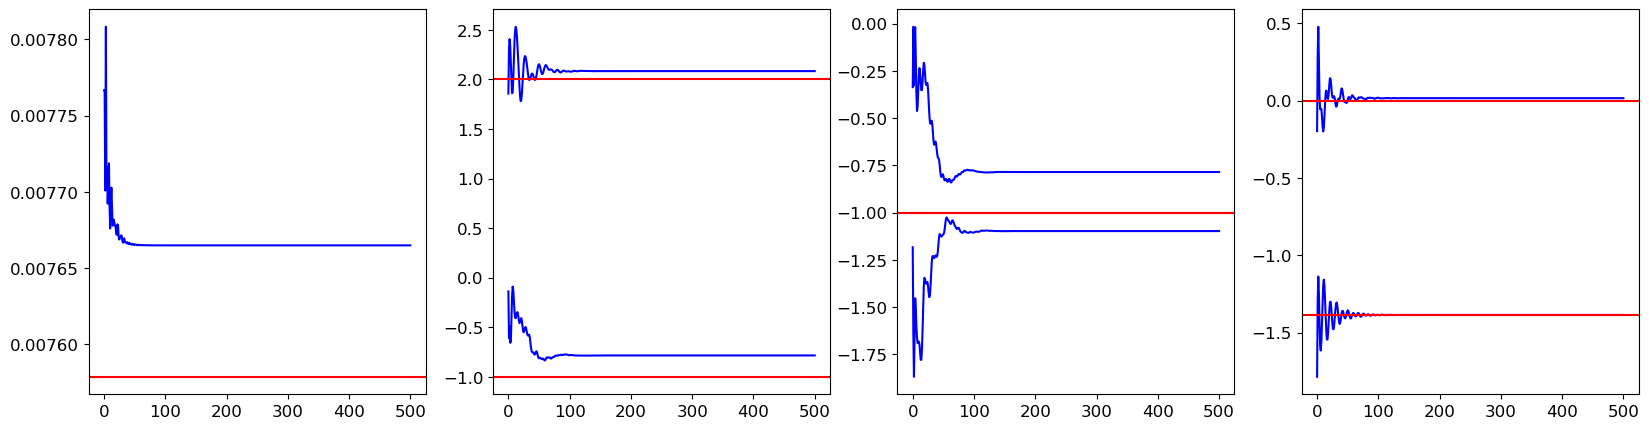

In [41]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

In [85]:
n_gradient_steps = 400

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.005, 0.005], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":2, "log_graph":1}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2024-07-23 09:35:43.337934: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_63', 224 bytes spill stores, 224 bytes spill loads



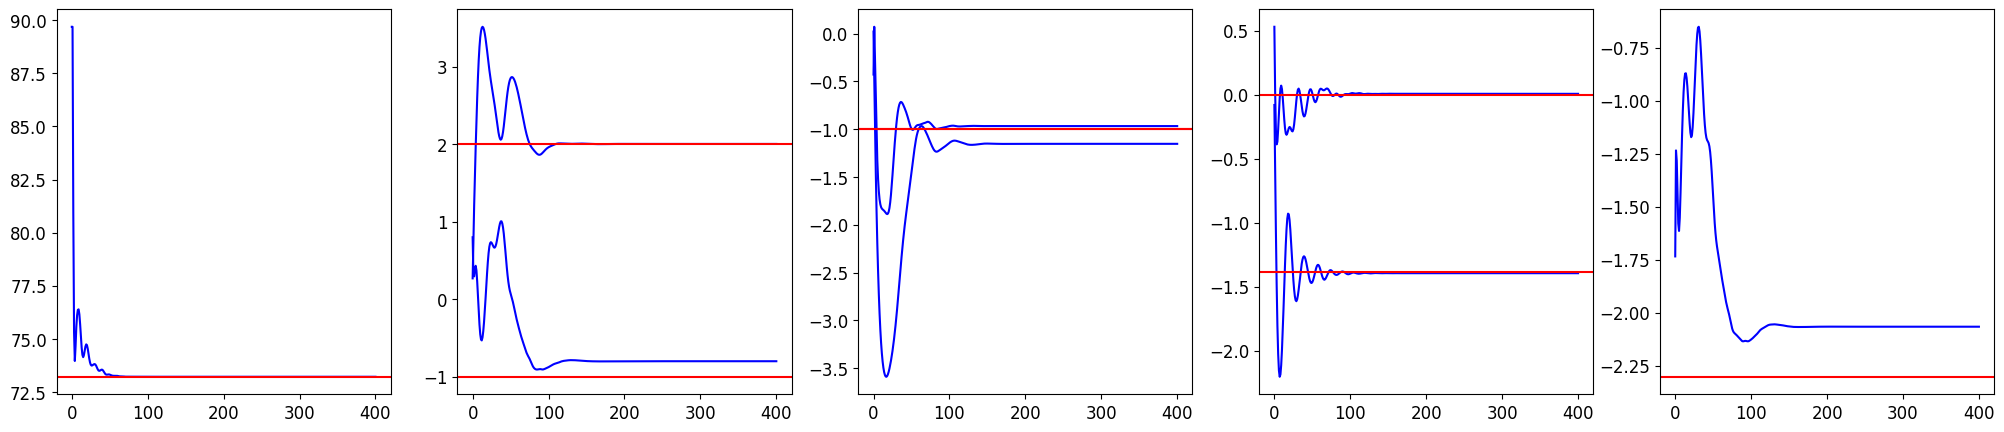

In [86]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

# Network SIR

In [87]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [89]:
N_pop = 1000

G = nx.watts_strogatz_graph(n = N_pop, k = 6, p = 0.1)
connection_matrix = tf.convert_to_tensor(nx.adjacency_matrix(G).todense(), dtype = tf.float32)

covariates = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]

SIR = network_SIR(connection_matrix, covariates)

In [90]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([1.0, 2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32)),}

2.3430089950561523


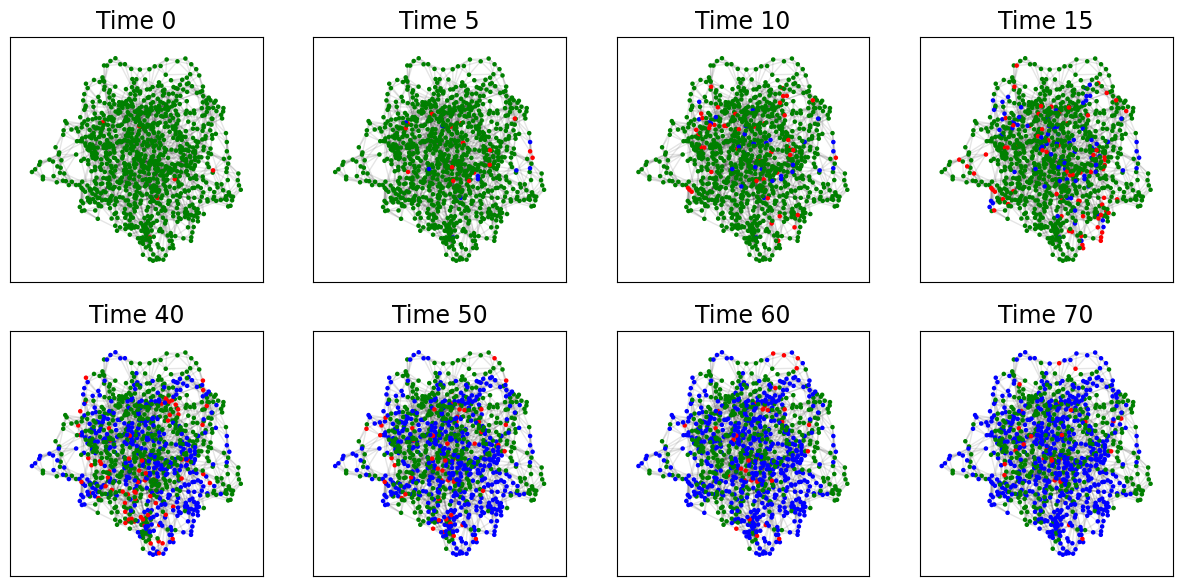

In [91]:
T    = 200
start = time.time()
X, Y = simulator(SIR, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

fig, ax = plt.subplots(2, 4, figsize = (15, 7), sharex=True, sharey=True)

pos = nx.spring_layout(G, seed = 10)

jump_list = [5, 10]
for i in range(2):
	for j in range(4):  

		t = jump_list[i]*(i*4+j)

		ax[i, j].set_title("Time "+str(t))

		color_map = np.where(X[t, :, 1]==1, 'red', 'green')
		color_map = np.where(X[t, :, 2]==1, "blue", color_map)

		nx.draw_networkx_nodes( G, pos, node_color = color_map, node_shape='o', node_size = 5000/N_pop,
			 ax = ax[i,j])
		nx.draw_networkx_edges( G, pos, alpha=0.1,
			 ax = ax[i,j])

In [92]:
os.chdir("Scripts/")
%run -i CAL.py
os.chdir("../")

The time lap is  1.0450124740600586
The log-likelihood is  -141.32962


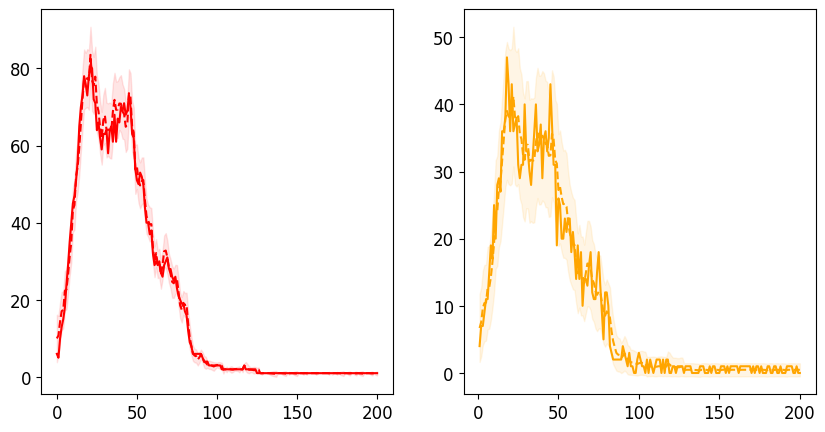

In [93]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIR, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [96]:
n_gradient_steps = 400

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":3}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIR, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

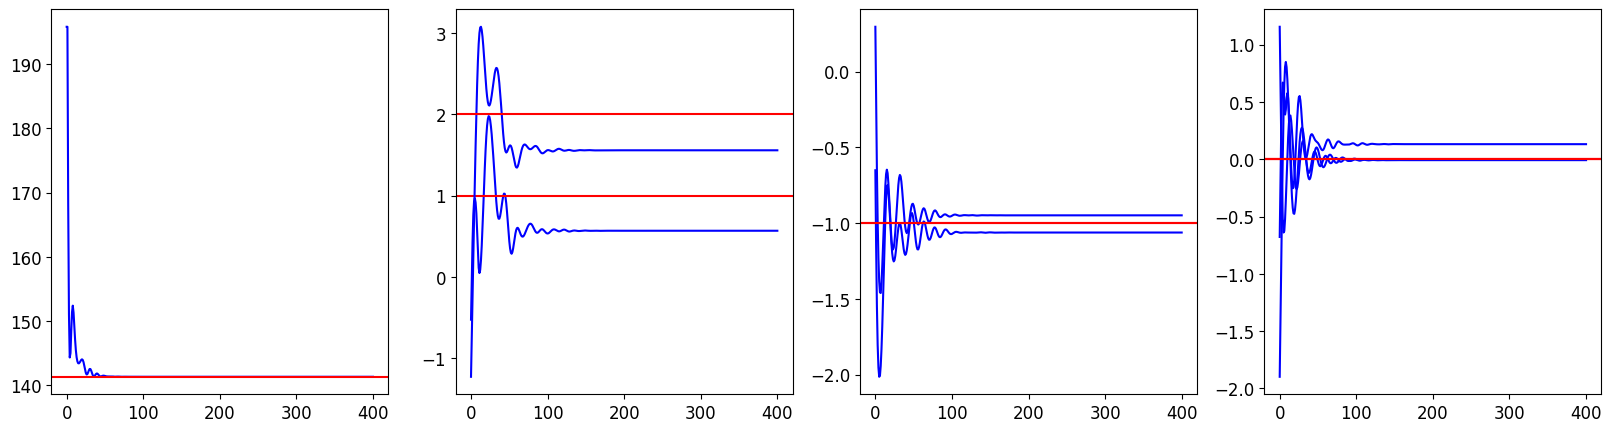

In [97]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIR, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

## Filtering performance

In [134]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [98]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([1.0, 2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32)),}

T    = 200
start = time.time()
X, Y = simulator(SIR, parameters, T, sample_size = 100)
print(time.time()-start)

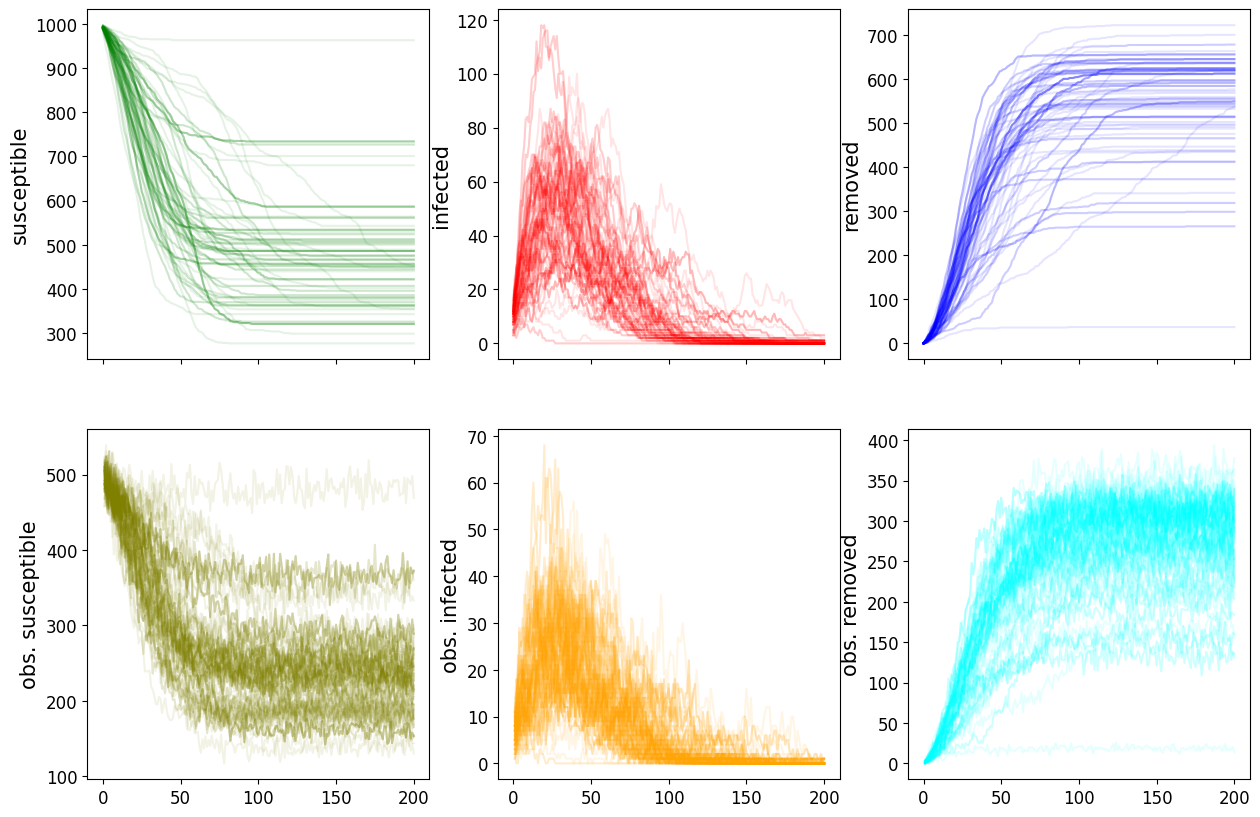

In [130]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10), sharex=True)

color_list   = ["green", "red", "blue"]
color_list_y = ["olive", "orange", "cyan"]

label_list   = ["susceptible", "infected", "removed"]
label_list_y = ["obs. susceptible", "obs. infected", "obs. removed"]

time_step = np.linspace(0, T, T+1)

for j in range(3):

	ax[0,j].set_ylabel(label_list[j])
	ax[1,j].set_ylabel(label_list_y[j])

	for i in np.random.choice(range(100), 100):

		ax[0,j].plot(time_step, np.sum(X[...,j], axis = -1)[:,i], color = color_list[j], alpha = 0.1)
		ax[1,j].plot(time_step[1:], np.sum(Y[...,j+1], axis = -1)[:,i], color = color_list_y[j], alpha = 0.1)

In [147]:
X[...,1]

<tf.Tensor: shape=(51, 2000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [148]:
np.abs(np.max(mean_Pi[...,1]) - np.max(np.sum(X[...,1], axis = 1)))>20

5.078003

In [1]:
# m_list = [6, 18 , 36]
# p_list = [0.0, 0.1, 0.5]

# T_list = [100, 75, 50]

# fig, ax = plt.subplots(len(m_list), len(p_list), figsize = (5*len(m_list), 5*len(p_list)), sharex = "col")


# for i in range(len(m_list)):
# 	for j in range(len(p_list)):
		
# 		if j==0:
# 			ax[i,j].set_ylabel("Infected")

# 		if i == (len(m_list)-1):
# 			ax[i,j].set_xlabel("Time")

# 		ax[i,j].set_title("m="+str(m_list[i])+", p="+str(p_list[j]))

# 		N_pop = 2000

# 		G = nx.watts_strogatz_graph(n = N_pop, k = m_list[i], p = p_list[j])
# 		connection_matrix = tf.convert_to_tensor(nx.adjacency_matrix(G).todense(), dtype = tf.float32)

# 		covariates = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]

# 		SIR = network_SIR(connection_matrix, covariates)

# 		observation_list = [#[0.0, 0.1, 0.0], 
# 		      		    [0.1, 0.1, 0.1],
# 				    #[0.0, 0.2, 0.0],
# 				    [0.2, 0.2, 0.2],
# 				    [0.0, 0.5, 0.0],
# 				    [0.5, 0.5, 0.5]]
		
# 		observation_label = [#[0.0, 0.1, 0.0], 
# 		      		    "SIR reported w.p. 0.1",
# 				    #[0.0, 0.2, 0.0],
# 				    "SIR reported w.p. 0.2",
# 				    "I reported w.p. 0.5",
# 				    "SIR reported w.p. 0.5",]
		
# 		colors_observation_list = [	#"dimgrey",
# 						"red",
# 						#"gold",
# 						"olivedrab",
# 						"cadetblue",
# 						"rebeccapurple",]

# 		for k in range(len(observation_list)):

# 			parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),
# 				"beta_l":tf.convert_to_tensor([1.0, 2.0], dtype = tf.float32),
# 				"beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
# 				"logit_prob_testing":logit(
# 					tf.convert_to_tensor(observation_list[k], dtype = tf.float32)),}

# 			T    = T_list[j]
# 			start = time.time()
# 			X, Y = simulator(SIR, parameters, T)
# 			print(time.time()-start)

# 			X, Y = X[:,0,...], Y[:,0,...]

# 			Pi, Mu, log_likelihood = CAL(SIR, parameters, Y)

# 			population = tf.reduce_sum(X, axis = 1)
# 			mean_Pi = tf.reduce_sum(Pi, axis = 1)
# 			var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

# 			time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

# 			if np.abs(np.max(mean_Pi[...,1]) - np.max(np.sum(X[...,1], axis = 1)))>40:
# 				right_limit = 10
# 			else:
# 				right_limit = -1

# 			ax[i,j].plot(time_steps, population[...,1], color = colors_observation_list[k], label = observation_label[k])
# 			# ax[i,j].plot(time_steps, mean_Pi[...,1], color = colors_observation_list[k], linestyle = "dashed")
# 			ax[i,j].fill_between(time_steps[:right_limit,], mean_Pi[:right_limit,...,1] - 1.96*tf.math.sqrt(var_Pi[:right_limit,...,1]), 
# 									 mean_Pi[:right_limit,...,1] + 1.96*tf.math.sqrt(var_Pi[:right_limit,...,1]), 
# 									 color = colors_observation_list[k], alpha = 0.2)
# 			ax[i,j].legend()


a